In [1]:
!date

Thu Oct 29 14:01:07 PDT 2020


# Splitting subclasses on isoforms

In [111]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata
import matplotlib.transforms as transforms
import glob
from lazydata import track
import scanpy as sc

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [112]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [113]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [170]:
import ast

In [171]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [172]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to two isoform genes

In [173]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [174]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 214 ms, sys: 262 ms, total: 477 ms
Wall time: 474 ms


In [175]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [176]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 6160 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 6160 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'high

# Cluster on the subclasses to see if there is an isoform that splits one 

In [177]:
from sklearn.cluster import KMeans

In [178]:
subclasses = np.unique(isoform.obs.subclass_label.values)

In [179]:
%%time

# isoform level

files = []
for s in subclasses:
    tmp = isoform[isoform.obs.eval(f"subclass_label== '{s}'")].copy()
    kmeans = KMeans(n_clusters=2, random_state=state).fit(tmp.X)
    tmp.obs["km"] = kmeans.labels_
    files.append(tmp)

CPU times: user 11min 20s, sys: 1min, total: 12min 21s
Wall time: 1min 52s


In [180]:
new_isoform = files[0].concatenate(*files[1:])

In [181]:
%%time

# gene level

files = []
for s in subclasses:
    tmp = gene[gene.obs.eval(f"subclass_label== '{s}'")].copy()
    kmeans = KMeans(n_clusters=2, random_state=state).fit(tmp.X)
    tmp.obs["km"] = kmeans.labels_
    files.append(tmp)

CPU times: user 6min 22s, sys: 28.5 s, total: 6min 50s
Wall time: 27.5 s


In [182]:
new_gene = files[0].concatenate(*files[1:])

# Plot new clusters

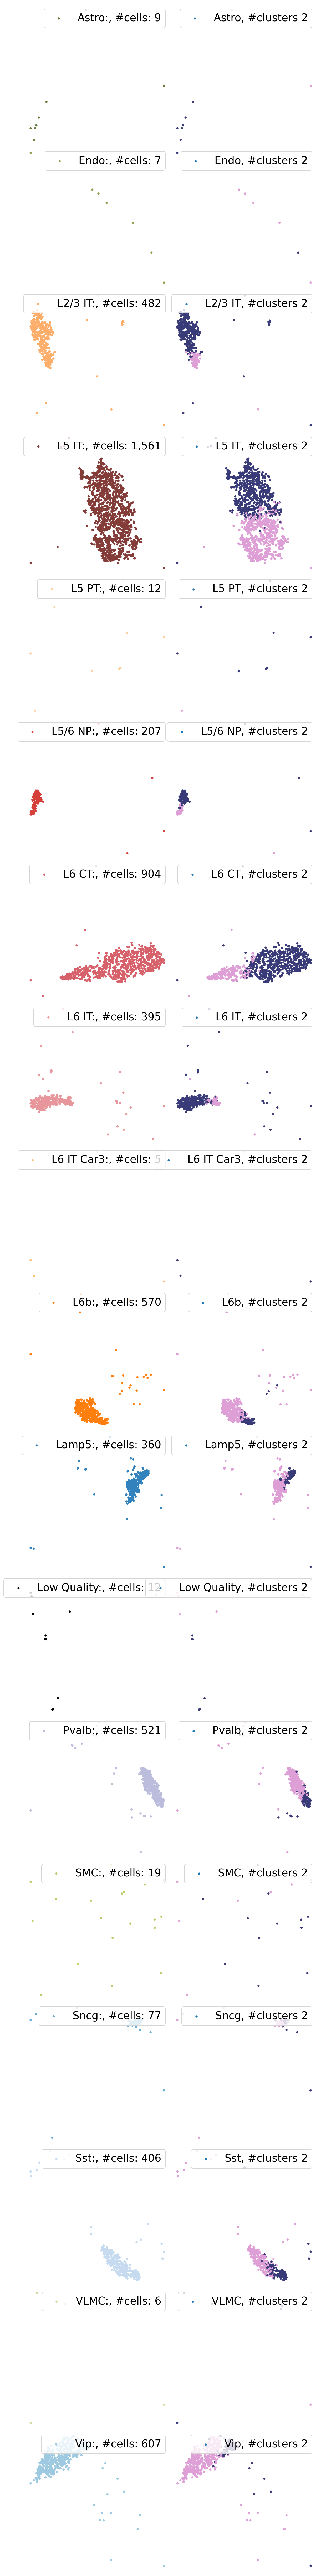

In [183]:
fig, axs = plt.subplots(figsize=(5*2, 5*len(subclasses)), ncols=2, nrows = len(subclasses))
fig.subplots_adjust(hspace=0, wspace=0)


for sidx, subclass in enumerate(subclasses):
    tmp = data[data.obs.eval(f"subclass_label == '{subclass}'")]

    ax = axs[sidx, 0]
    XX = tmp.obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    color = tmp.obs.subclass_label.map(cluster_cmap)
    ax.scatter(x, y, s=10, color = color, label=subclass+":, #cells: {:,}".format(x.shape[0]))
    ax.set_axis_off()
    ax.legend(loc="upper right")

    ax = axs[sidx, 1]
    XX = tmp.obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    color = tmp.obs.km.astype(int)
    ax.scatter(x, y,s=10, c = color, cmap="tab20b", label=subclass+", #clusters {:,}".format(np.unique(color).shape[0]))
    ax.legend(loc="upper right")
    

    ax.set_axis_off()

fig.show()

In [184]:
isoform = new_isoform[new_isoform.obs.eval("subclass_label == 'L6 CT'")].copy()
gene = new_gene[new_gene.obs.eval("subclass_label == 'L6 CT'")].copy()

In [185]:
isoform

AnnData object with n_obs × n_vars = 904 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain', 'km', 'batch'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'

In [186]:
gene

AnnData object with n_obs × n_vars = 904 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain', 'km', 'batch'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'

# determine the isoforms

In [187]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [188]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
gene_features = gene.var.gene_name.values
assignments   = gene.obs.km.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw, corr_method)
s_gene = stat

DEBUG:root:1 of 2 assignments: 0
DEBUG:root:2 of 2 assignments: 1


CPU times: user 192 ms, sys: 44 ms, total: 236 ms
Wall time: 319 ms


In [189]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.km.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_isoform_raw, stat = dexpress(mat, components, features, assignments, 
                      nan_cutoff=nan_cutoff)

p_isoform = correct_pval(p_isoform_raw/2, corr_method)
s_isoform = stat

DEBUG:root:1 of 2 assignments: 0
DEBUG:root:2 of 2 assignments: 1


CPU times: user 514 ms, sys: 296 ms, total: 811 ms
Wall time: 807 ms


In [190]:
repeat_col = gene.var["num_isoforms"]

p1 = p_isoform
p2 = np.repeat(p_gene, repeat_col, axis=1)

s1 = s_isoform
s2 = np.repeat(s_gene, repeat_col, axis=1)

In [191]:
logger.setLevel(logging.ERROR)

In [192]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

p2_mask = np.logical_or(np.logical_and(p2>alpha, s2>tcrit), np.logical_and(p2<alpha, s2<tcrit))

mask = np.logical_and(p1_mask, p2_mask)
bool_mask = mask

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [193]:
bool_mask.sum()

304

In [194]:
markers_isoform = pd.DataFrame(index=unique, columns=["transcript_name", "p_raw", "p_bonferroni"])

In [195]:
assignments = gene.obs.km.values
unique = np.unique(assignments)

In [196]:
isoform_features = isoform.var.transcript_name.values

for uidx, u in enumerate(unique):
    mask = np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_isoform[uidx][mask]
    p_raw = p_isoform_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_isoform.loc[u]["transcript_name"] = fsorted
    markers_isoform.loc[u]["p_raw"] = p_raw_sorted
    markers_isoform.loc[u]["p_bonferroni"] = psorted

In [197]:
markers_isoform

,transcript_name,p_raw,p_bonferroni
0,"[App-205_ENSMUST00000227654, Napb-202_ENSMUST0...","[2.2460210028549958e-58, 1.160495689482501e-35...","[6.948402875482357e-54, 3.590167489767539e-31,..."
1,"[Ensa-201_ENSMUST00000037983, Nptn-212_ENSMUST...","[2.279396018855471e-46, 4.149718159923232e-46,...","[7.051653493732228e-42, 1.2837775585446506e-41..."


In [198]:
identified_isoforms = markers_isoform["transcript_name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [199]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [200]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

304 isoforms from 290 genes identified.


In [201]:
markers_isoform = markers_isoform.apply(pd.Series.explode).reset_index()

In [202]:
markers_isoform

,index,transcript_name,p_raw,p_bonferroni
0,0,App-205_ENSMUST00000227654,2.24602e-58,6.9484e-54
1,0,Napb-202_ENSMUST00000136513,1.1605e-35,3.59017e-31
2,0,Dnm1-206_ENSMUST00000129156,5.3751e-33,1.66287e-28
3,0,Olfm1-205_ENSMUST00000152415,1.18539e-26,3.66718e-22
4,0,Klf10-204_ENSMUST00000228416,1.64626e-25,5.09296e-21
...,...,...,...,...
299,1,Tmem165-201_ENSMUST00000031144,2.71595e-07,0.00840219
300,1,Pdhb-201_ENSMUST00000022268,2.8271e-07,0.00874605
301,1,Ik-201_ENSMUST00000007042,2.97818e-07,0.00921346
302,1,Ube2g1-201_ENSMUST00000021148,3.07613e-07,0.00951648


# Plot the gene expression and the marker isoform expression

In [277]:
i = "App-205_ENSMUST00000227654"
# i="Dnm1-206_ENSMUST00000129156"
# i="Lztr1-211_ENSMUST00000232372"

In [279]:
g = "App_ENSMUSG00000022892"
# g = "Dnm1_ENSMUSG00000026825"
# g = gene.var[gene.var.gene_name.str.contains(f"{i.split('-')[0]}")].index.values[0]
print(g)

App_ENSMUSG00000022892


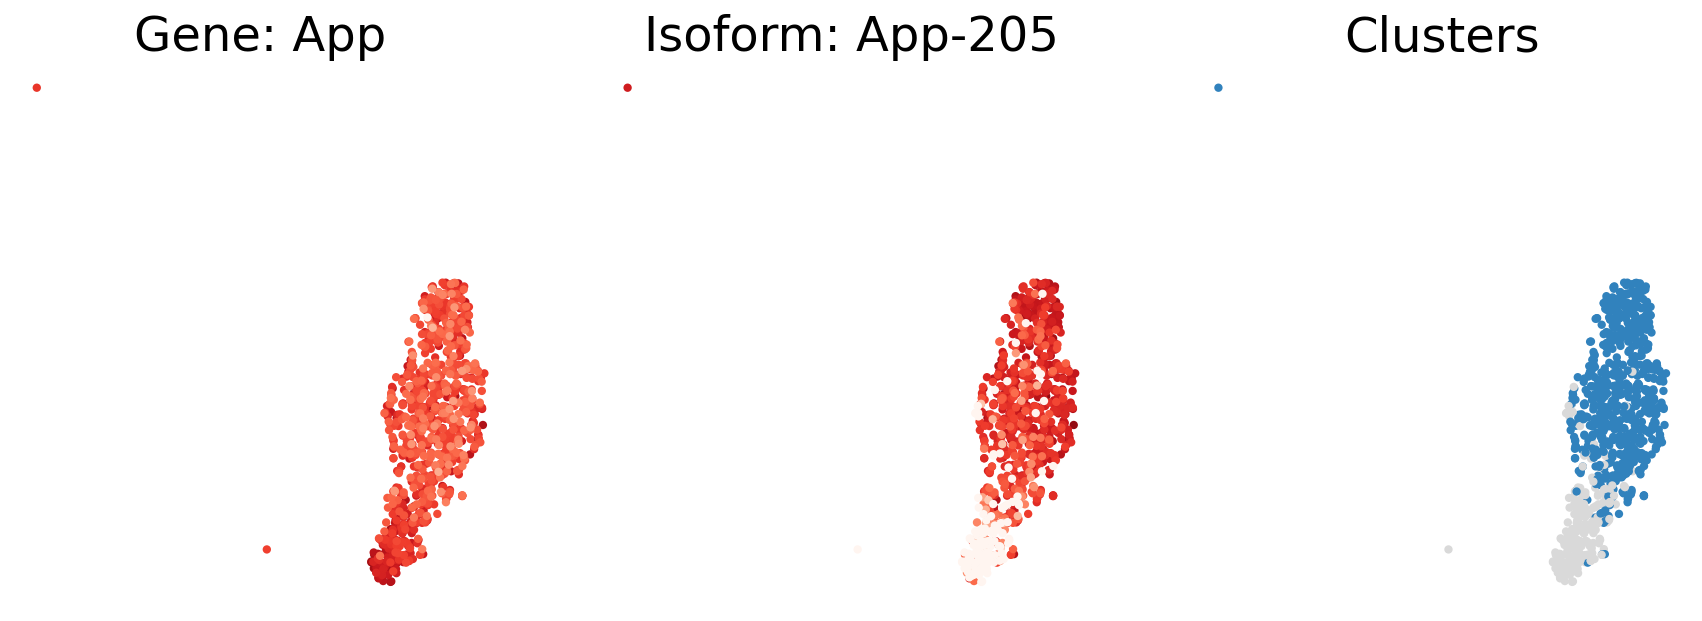

In [413]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

X = gene.obsm["X_nca_tsne"]

Yi = isoform.layers["log1p"][:, isoform.var.index.values == i]
Yg = gene.layers["log1p"][:, gene.var.index.values == g]

ax = axs[0] # gene

x = X[:,0]
y = X[:,1]
c = nd(Yg.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=10)
ax.set_axis_off()
ax.set_title(f"Gene: {g.split('_')[0]}")


ax = axs[1] # isoform

x = X[:,0]
y = X[:,1]
c = nd(Yi.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=10)
ax.set_axis_off()
ax.set_title(f"Isoform: {i.split('_')[0]}")

ax = axs[2] # clusters

x = X[:,0]
y = X[:,1]
c = isoform.obs.km.values

ax.scatter(x,y, c=c, cmap="tab20c", s=10)
ax.set_axis_off()
ax.set_title("Clusters")

#plt.savefig(f"../../figures/split_subclass_{i.split('_')[0]}.png",bbox_inches='tight', dpi=300)

fig.show()

# Marker genes

In [235]:
p1 = p_gene
s1 = s_gene

In [236]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

bool_mask = p1_mask

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [237]:
bool_mask.sum()

2559

In [238]:
assignments = gene.obs.km.values
unique = np.unique(assignments)

In [239]:
unique

array([0, 1], dtype=int32)

In [240]:
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_raw", "p_bonferroni"])

In [241]:
gene_features = gene.var.index.values

for uidx, u in enumerate(unique):
    mask = bool_mask[uidx] # np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_gene[uidx][mask]
    p_raw = p_gene_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = gene_features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_gene.loc[u]["gene_name"] = fsorted
    markers_gene.loc[u]["p_raw"] = p_raw_sorted
    markers_gene.loc[u]["p_bonferroni"] = psorted

In [242]:
markers_gene

,gene_name,p_raw,p_bonferroni
0,"[Cox6c_ENSMUSG00000014313, Cox7a2_ENSMUSG00000...","[3.035993247312606e-79, 4.554155683593351e-79,...","[3.6100995703794197e-75, 5.415346523360854e-75..."
1,"[Aplp1_ENSMUSG00000006651, Pkm_ENSMUSG00000032...","[3.7466454469207836e-150, 1.658002308721138e-1...","[4.455136100933504e-146, 1.9715305453003052e-1..."


In [243]:
identified_genes = markers_gene["gene_name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [244]:
print("{} genes identified.".format(identified_genes.nunique()))

2559 genes identified.


In [245]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()

In [439]:
markers_gene.sort_values("p_raw")

,index,gene_name,p_raw,p_bonferroni,gene
430,1,Aplp1_ENSMUSG00000006651,3.74665e-150,4.45514e-146,Aplp1
431,1,Pkm_ENSMUSG00000032294,1.658e-145,1.97153e-141,Pkm
432,1,Atp6v1b2_ENSMUSG00000006273,7.89915e-138,9.39288e-134,Atp6v1b2
433,1,Ubc_ENSMUSG00000008348,2.16536e-115,2.57483e-111,Ubc
434,1,Hspa8_ENSMUSG00000015656,8.31803e-114,9.89096e-110,Hspa8
...,...,...,...,...,...
2554,1,Zfp277_ENSMUSG00000055917,8.24826e-07,0.009808,Zfp277
2555,1,Exoc3_ENSMUSG00000034152,8.35241e-07,0.00993185,Exoc3
2556,1,Tmem147os_ENSMUSG00000097320,8.36789e-07,0.00995026,Tmem147os
2557,1,Nos1ap_ENSMUSG00000038473,8.4015e-07,0.00999022,Nos1ap


# Compare gene vs isoform

In [250]:
markers_isoform["gene"] = markers_isoform["transcript_name"].apply(lambda x: x.split("-")[0])

In [251]:
markers_isoform

,index,transcript_name,p_raw,p_bonferroni,gene
0,0,App-205_ENSMUST00000227654,2.24602e-58,6.9484e-54,App
1,0,Napb-202_ENSMUST00000136513,1.1605e-35,3.59017e-31,Napb
2,0,Dnm1-206_ENSMUST00000129156,5.3751e-33,1.66287e-28,Dnm1
3,0,Olfm1-205_ENSMUST00000152415,1.18539e-26,3.66718e-22,Olfm1
4,0,Klf10-204_ENSMUST00000228416,1.64626e-25,5.09296e-21,Klf10
...,...,...,...,...,...
299,1,Tmem165-201_ENSMUST00000031144,2.71595e-07,0.00840219,Tmem165
300,1,Pdhb-201_ENSMUST00000022268,2.8271e-07,0.00874605,Pdhb
301,1,Ik-201_ENSMUST00000007042,2.97818e-07,0.00921346,Ik
302,1,Ube2g1-201_ENSMUST00000021148,3.07613e-07,0.00951648,Ube2g1


In [281]:
markers_gene

,index,gene_name,p_raw,p_bonferroni,gene
0,0,Cox6c_ENSMUSG00000014313,3.03599e-79,3.6101e-75,Cox6c
1,0,Cox7a2_ENSMUSG00000032330,4.55416e-79,5.41535e-75,Cox7a2
2,0,Ndufa4_ENSMUSG00000029632,2.00186e-76,2.38041e-72,Ndufa4
3,0,Atp5l_ENSMUSG00000038717,1.84846e-75,2.198e-71,Atp5l
4,0,Cox6b1_ENSMUSG00000036751,1.94993e-75,2.31866e-71,Cox6b1
...,...,...,...,...,...
2554,1,Zfp277_ENSMUSG00000055917,8.24826e-07,0.009808,Zfp277
2555,1,Exoc3_ENSMUSG00000034152,8.35241e-07,0.00993185,Exoc3
2556,1,Tmem147os_ENSMUSG00000097320,8.36789e-07,0.00995026,Tmem147os
2557,1,Nos1ap_ENSMUSG00000038473,8.4015e-07,0.00999022,Nos1ap


### Compare the two

In [253]:
markers_gene["gene"] = markers_gene["gene_name"].apply(lambda x: x.split("_")[0])

In [260]:
markers_isoform[~markers_isoform.gene.isin(markers_gene.gene.values)].sort_values("p_raw")

,index,transcript_name,p_raw,p_bonferroni,gene
98,1,Ensa-201_ENSMUST00000037983,2.2794e-46,7.05165e-42,Ensa
99,1,Nptn-212_ENSMUST00000177292,4.14972e-46,1.28378e-41,Nptn
100,1,Zfp706-201_ENSMUST00000078976,7.1084e-46,2.19909e-41,Zfp706
101,1,Lztr1-211_ENSMUST00000232372,6.72431e-38,2.08027e-33,Lztr1
102,1,Lztr1-201_ENSMUST00000023444,4.43978e-33,1.37351e-28,Lztr1
...,...,...,...,...,...
95,0,Prdm11-203_ENSMUST00000130441,3.00811e-07,0.00930605,Prdm11
302,1,Ube2g1-201_ENSMUST00000021148,3.07613e-07,0.00951648,Ube2g1
96,0,Ppp1r11-203_ENSMUST00000174711,3.14691e-07,0.00973544,Ppp1r11
303,1,Mfsd6-205_ENSMUST00000156876,3.15807e-07,0.00976995,Mfsd6


# effect sizes

In [289]:
markers_gene.query("gene == 'App'")

,index,gene_name,p_raw,p_bonferroni,gene
745,1,App_ENSMUSG00000022892,4.44864e-40,5.28988e-36,App


In [442]:
i = "App-205_ENSMUST00000227654"
g = "App_ENSMUSG00000022892"

# isoform
vector = nd(isoform.layers["log1p"][:, isoform.var.index.values == i].todense())
mask = isoform.obs.eval("km == '0'")
print(vector[mask].mean(), vector[~mask].mean())

vector = nd(gene.layers["log1p"][:, gene.var.index.values == g].todense())
mask = gene.obs.eval("km == '0'")
print(vector[mask].mean(), vector[~mask].mean())

4.812016581658722 1.8631524588006454
5.65849099717937 6.0555913161324


In [433]:
def vplot(data, xlabels, ax):
    violins = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor('#D43F3A')
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = didx+1
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        print(mean)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


In [434]:
gene.var[gene.var.gene_name.str.contains("Ensa")]

,transcript_id,gene_id,gene_name,transcript_name,length,txn_list,num_isoforms,gene_counts,dispersion,pass_disp_filter,highly_variable,means,dispersions,dispersions_norm
Ensa_ENSMUSG00000038619,ENSMUST00000199421,ENSMUSG00000038619,Ensa_ENSMUSG00000038619,Ensa-204_ENSMUST00000199421,998,"['ENSMUST00000199421', 'ENSMUST00000058230', '...",4,4171.094238,0.32696,True,True,6.180273,4.844513,0.66159


In [440]:
g = "Aplp1_ENSMUSG00000006651"

4.812016581658722
1.8631524588006454
5.65849099717937
6.0555913161324


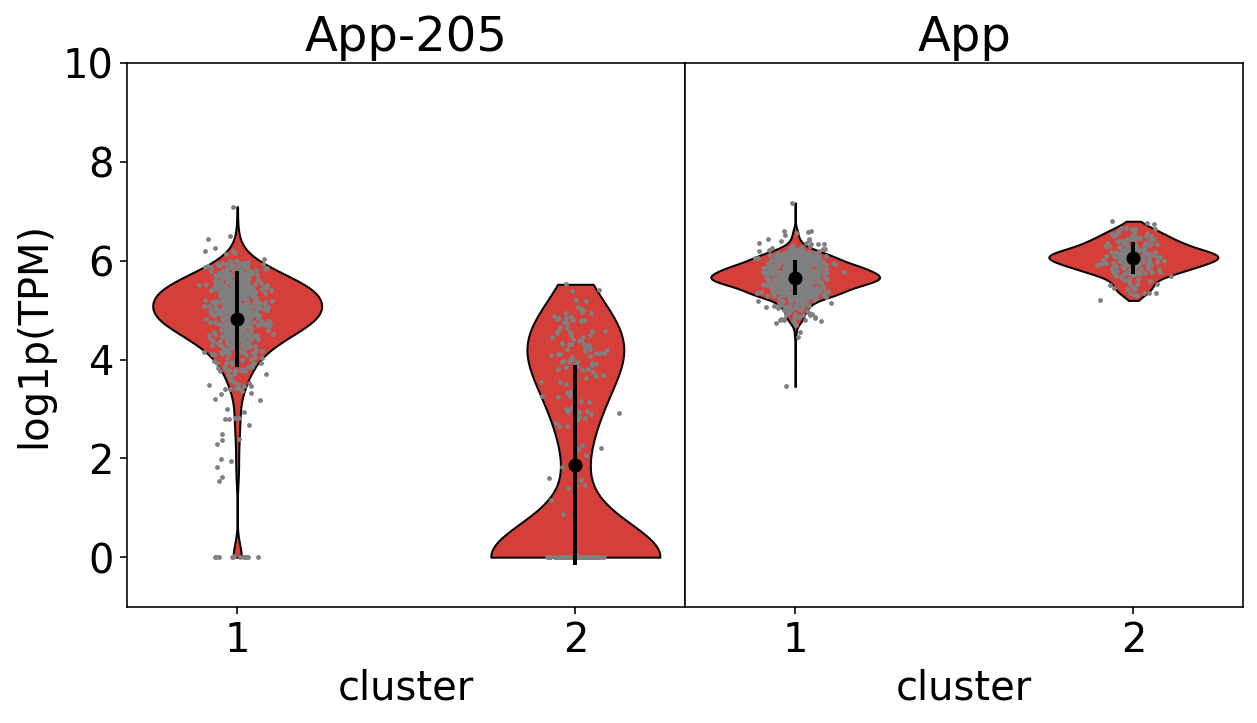

In [443]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

km = np.unique(isoform.obs.km.values)
iso_vector = nd(isoform.layers["log1p"][:, isoform.var.index.values == i].todense())
gene_vector = nd(gene.layers["log1p"][:, gene.var.index.values == g].todense())

lidx = np.arange(len(km)) + 1
labels = [f"{i}" for i in lidx]
kwd = {
    "xticks" : lidx,
    "xticklabels": labels,
    "xlabel":"cluster",
    "ylim": (-1, 10),
    "ylabel": "log1p(TPM)"
}

ax = axs[0]
mask = isoform.obs.eval(f"km == '0'")
data = [iso_vector[mask], iso_vector[~mask]]

vplot(data, [], ax)

ax.set_title(f"{i.split('_')[0]}")
ax.set(**kwd)



ax = axs[1]
mask = gene.obs.eval(f"km == '0'")
data = [gene_vector[mask], gene_vector[~mask]]

vplot(data, [], ax)

ax.set_title(f"{g.split('_')[0]}")
kwd["yticks"] = []
kwd["yticklabels"] = []
kwd["ylabel"] = ""
ax.set(**kwd)

fig.show()

In [419]:
from scipy import spatial

In [421]:
spatial.distance.hamming(isoform.obs.km.values, gene.obs.km.values)

0.028761061946902654

In [422]:
isoform.obs[isoform.obs.km.values== gene.obs.km.values].shape

(878, 14)

In [423]:
isoform.shape

(904, 61873)